In [2]:
"""
A simple example of the Stiefel landing algorithm on PCA problem
"""
from time import time

import matplotlib.pyplot as plt

import numpy as np

import torch

import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

from models import VGG16, ResNet18

from solvers import *
from experiments.utils import *

from scipy.linalg import eigh

/opt/mambaforge/envs/landing/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [39]:
def dataset_simulated_ica(n_samples = 10000, n_features = 10, p = 10, batch_size=100, st_dev = 1, device = 'cpu', random_state=42):
    rng = np.random.RandomState(random_state)
    sources = st_dev*rng.laplace(size=(n_samples, n_features))
    q_haar, _ = np.linalg.qr(rng.randn(n_features,p))
    mixing = q_haar @ q_haar.T
    #X = np.dot(sources, mixing.T)
    #W = np.linalg.pinv(sqrtm(X.T.dot(X) / n_samples))
    X = np.dot(sources, mixing.T)
    #mixing = np.dot(W, mixing)
    X = torch.from_numpy(X).to(device=device)
    mixing = torch.from_numpy(mixing).to(device=device)
    dataset = torch.utils.data.TensorDataset(X)
    dataloader = torch.utils.data.DataLoader(dataset,
                        batch_size=batch_size, shuffle=False)
    return dict(dataloader=dataloader, mixing=mixing)

n_samples = 100000
n_features = 100
p = 10
batch_size = 512
data = dataset_simulated_ica(device = 'cuda', n_samples = n_samples, n_features=n_features, p = p, st_dev = 1, batch_size = batch_size)
dataloader = data['dataloader']
mixing = data['mixing']

device = 'cuda'

A = dataloader.dataset.tensors[0]
AtA = A.T @ A / A.shape[0]

In [40]:
evals = torch.linalg.eigvals(AtA)
print(evals[0]/evals[-1])

tensor(3.4688e+16+0.j, device='cuda:0', dtype=torch.complex128)


In [41]:
per_epoch_log = False
n_epochs = 5
lr_rate = 1e-1
omega = 1
lr_milestones = [3,4]

In [42]:
x_l, out_l = LandingICA(loader=dataloader, mixing_true=mixing, p=p, grad_type='precon', averaging=False, learning_rate = lr_rate, omega = omega, regul_type='matrix', n_epochs=n_epochs,device=device, lr_milestones=lr_milestones, per_epoch_log=per_epoch_log, init_batch_size = 10)

x_la, out_la = LandingICA(loader=dataloader, mixing_true=mixing, p=p, grad_type='precon', averaging=True, learning_rate = lr_rate, omega = omega, regul_type='matrix', n_epochs=n_epochs,device=device, lr_milestones=lr_milestones, per_epoch_log=per_epoch_log, init_batch_size = 10)

Epoch/Iter: (0, 0), Distance: (0.13875), Amari distance: (1.59561), Objective: 3.75003
Epoch/Iter: (0, 1), Distance: (0.24801), Amari distance: (1.60128), Objective: 3.71714
Epoch/Iter: (0, 2), Distance: (0.23136), Amari distance: (1.59828), Objective: 3.72178
Epoch/Iter: (0, 3), Distance: (0.25646), Amari distance: (1.59506), Objective: 3.68443
Epoch/Iter: (0, 4), Distance: (0.23559), Amari distance: (1.59837), Objective: 3.68278
Epoch/Iter: (0, 5), Distance: (0.21484), Amari distance: (1.59590), Objective: 3.70917
Epoch/Iter: (0, 6), Distance: (0.24727), Amari distance: (1.58668), Objective: 3.66942
Epoch/Iter: (0, 7), Distance: (0.23074), Amari distance: (1.58785), Objective: 3.72186
Epoch/Iter: (0, 8), Distance: (0.24022), Amari distance: (1.58224), Objective: 3.64643
Epoch/Iter: (0, 9), Distance: (0.23323), Amari distance: (1.58162), Objective: 3.64458
Epoch/Iter: (0, 10), Distance: (0.23090), Amari distance: (1.57978), Objective: 3.65255
Epoch/Iter: (0, 11), Distance: (0.22654), 

In [43]:
x_r, out_r = RiemannianRollingICA(loader=dataloader, mixing_true=mixing, p=p, averaging=True, learning_rate = 1e-2, n_epochs=n_epochs,device=device, lr_milestones=lr_milestones, per_epoch_log=per_epoch_log,init_batch_size=10)

Epoch/Iter: (0, 0), Distance: (0.13875), Amari distance: (1.58714), Objective: 3.74855
Epoch/Iter: (0, 1), Distance: (0.53687), Amari distance: (1.57480), Objective: 3.79374
Epoch/Iter: (0, 2), Distance: (0.32748), Amari distance: (1.57711), Objective: 3.79354
Epoch/Iter: (0, 3), Distance: (0.26827), Amari distance: (1.56940), Objective: 3.76863
Epoch/Iter: (0, 4), Distance: (0.21718), Amari distance: (1.57994), Objective: 3.76875
Epoch/Iter: (0, 5), Distance: (0.19812), Amari distance: (1.58152), Objective: 3.77324
Epoch/Iter: (0, 6), Distance: (0.18664), Amari distance: (1.58551), Objective: 3.75620
Epoch/Iter: (0, 7), Distance: (0.18159), Amari distance: (1.58932), Objective: 3.77298


Epoch/Iter: (0, 8), Distance: (0.15778), Amari distance: (1.58675), Objective: 3.75180
Epoch/Iter: (0, 9), Distance: (0.13986), Amari distance: (1.59115), Objective: 3.74969
Epoch/Iter: (0, 10), Distance: (0.13875), Amari distance: (1.58715), Objective: 3.74855
Epoch/Iter: (0, 11), Distance: (0.12712), Amari distance: (1.58469), Objective: 3.74641
Epoch/Iter: (0, 12), Distance: (0.12007), Amari distance: (1.58355), Objective: 3.73383
Epoch/Iter: (0, 13), Distance: (0.12326), Amari distance: (1.58363), Objective: 3.73206
Epoch/Iter: (0, 14), Distance: (0.12203), Amari distance: (1.58673), Objective: 3.74450
Epoch/Iter: (0, 15), Distance: (0.11998), Amari distance: (1.58712), Objective: 3.74400
Epoch/Iter: (0, 16), Distance: (0.11830), Amari distance: (1.58795), Objective: 3.73596
Epoch/Iter: (0, 17), Distance: (0.11819), Amari distance: (1.58809), Objective: 3.73520
Epoch/Iter: (0, 18), Distance: (0.11704), Amari distance: (1.58758), Objective: 3.73481
Epoch/Iter: (0, 19), Distance: (0.

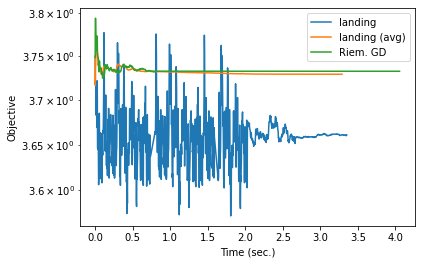

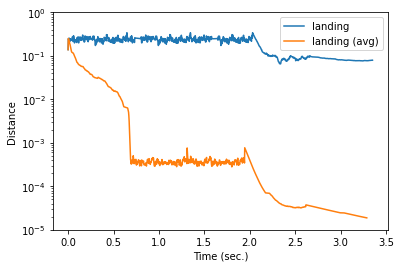

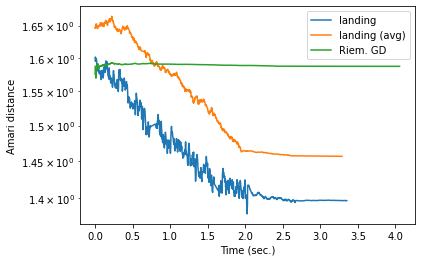

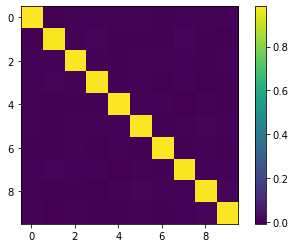

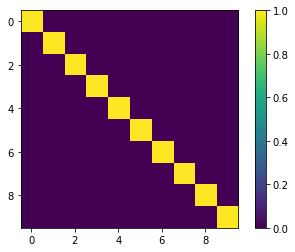

In [44]:
loc_min = 0 # out_l['fx'][-1]
xlims = None
plt.semilogy(out_l['time'], np.abs(np.array(out_l['fx']) - loc_min) , label='landing')
plt.semilogy(out_la['time'], np.abs(np.array(out_la['fx']) - loc_min), label='landing (avg)')
plt.semilogy(out_r['time'], np.abs(np.array(out_r['fx']) - loc_min), label='Riem. GD')
plt.xlabel('Time (sec.)')
plt.ylabel('Objective')
plt.legend()
plt.xlim(xlims)
plt.show()

plt.semilogy(out_l['time'],out_l['distance'], label='landing')
plt.semilogy(out_la['time'],out_la['distance'], label='landing (avg)')
#plt.semilogy(out_r['time'],out_r['distance'], label='Riem. GD')
plt.xlabel('Time (sec.)')
plt.ylabel('Distance')
plt.legend()
plt.xlim(xlims)
plt.ylim([1e-5,1])
plt.show()

plt.semilogy(out_l['time'],out_l['amari_distance'], label='landing')
plt.semilogy(out_la['time'],out_la['amari_distance'], label='landing (avg)')
plt.semilogy(out_r['time'],out_r['amari_distance'], label='Riem. GD')
plt.xlabel('Time (sec.)')
plt.ylabel('Amari distance')
plt.legend()
plt.xlim(xlims)
plt.show()

plt.imshow((x_l.T @ AtA @ x_l).cpu().numpy())
plt.colorbar()
plt.show()

plt.imshow((x_r.T @ AtA @ x_r).cpu().numpy())
plt.colorbar()
plt.show()

In [63]:
plt.semilogy(out['time'],out['amari_distance'])
plt.xlabel('sec')

NameError: name 'out' is not defined

In [9]:
out['distance']

[2.786201040025892,
 1.6908125792466338,
 1.6908125792466344,
 1.6908125792466322,
 1.6908125792466384,
 1.690812579246635,
 1.690812579246633,
 1.6908125792466342,
 1.69081257924663,
 1.6908125792466353,
 1.6908125792466349,
 1.6908125792466375,
 1.6908125792466373,
 1.6908125792466395,
 1.6908125792466349,
 1.6908125792466373,
 1.6908125792466309,
 1.6908125792466373,
 1.690812579246637,
 1.6908125792466353,
 1.6908125792466357,
 1.6908125792466353,
 1.6908125792466322,
 1.690812579246633,
 1.6908125792466386,
 1.690812579246631,
 1.6908125792466342,
 1.6908125792466362,
 1.6908125792466382,
 1.6908125792466364,
 1.6908125792466338,
 1.6908125792466342,
 1.6908125792466349,
 1.6908125792466362,
 1.6908125792466344,
 1.6908125792466349,
 1.6908125792466355,
 1.6908125792466373,
 1.6908125792466366,
 1.6908125792466335,
 1.6908125792466382,
 1.6908125792466366,
 1.6908125792466338,
 1.6908125792466335,
 1.6908125792466366,
 1.6908125792466338,
 1.6908125792466364,
 1.6908125792466357,


Text(0.5, 0, 'sec')

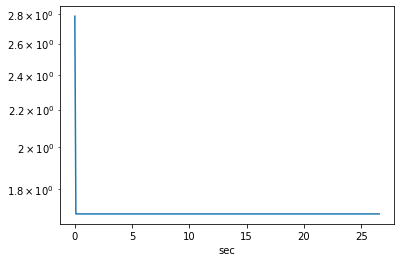

In [8]:
plt.semilogy(out['time'],out['distance'])
plt.xlabel('sec')

In [ ]:
def sigma(x):
    return(torch.log(torch.cosh(x)))

def amari_distance(W, A):
    """
    Computes the Amari distance between two matrices W and A.
    It cancels when WA is a permutation and scale matrix.
    Parameters
    ----------
    W : ndarray, shape (n_features, n_features)
        Input matrix
    A : ndarray, shape (n_features, n_features)
        Input matrix
    Returns
    -------
    d : float
        The Amari distance
    """
    P = W @ A

    def s(r):
        val_max, _ = torch.max(r ** 2, axis=1)
        return torch.sum(torch.sum(r ** 2, axis=1) / val_max - 1)

    return (s(torch.abs(P)) + s(torch.abs(P.T))) / (2 * P.shape[0])

In [ ]:
A_full = dataloader.dataset.tensors[0]
n_samples, n_features = dataloader.dataset.tensors[0].shape 
Id =  torch.eye(p,p, device = device)
AtA_full = A_full.T @ A_full / n_samples
objective = lambda x: torch.sum(sigma(A_full @ x)).item() / n_samples
distance = lambda x: torch.linalg.norm(x.T@AtA_full@x-Id).item()

In [ ]:
# Initialize based on first batch

batch_init = iter(dataloader).__next__()
batch_init = batch_init[0].to(device)

x0,_ = torch.linalg.qr(torch.randn(n_features, p, device=device, dtype=float))
Ax0 = batch_init @ x0
R = torch.linalg.cholesky(Ax0.T @ Ax0 / batch_init.size(1));
x0 = torch.linalg.solve(R, x0.T).T

print(objective(x0))
print(distance(x0))
x = torch.nn.Parameter(x0).to(device)

0.09893519955455062
3.098966139020586


In [ ]:
learning_rate = 1e-3
omega=10
grad_type = 'precon'
regul_type = 'matrix'

optimizerICA = LandingGeneralizedStiefel((x,), lr=learning_rate, omega=omega,grad_type=grad_type,regul_type=regul_type)
    
#optimizerICA = RiemannianGeneralizedStiefel((x,), lr=learning_rate,eps_regul=1e-8) 

In [ ]:
n_epochs = 500
averaging = False
distances = []
obj_values = []
amari_distances = []
for epoch in range(n_epochs):
    iteration = 0
    if averaging and epoch == 0:
            n_samples_seen = 0
            AtA = torch.zeros_like(AtA_full, device=device)
    for ind, A_sample in enumerate(dataloader):
        A_sample = A_sample[0].to(device)
        n_batch =  A_sample.size(0)
        if averaging and epoch == 0:
                AtA = (AtA*n_samples_seen + A_sample.T@A_sample)/(n_samples_seen+n_batch)
                n_samples_seen = n_samples_seen + n_batch
        elif not averaging:
                AtA = A_sample.T@A_sample/n_batch
        if regul_type == 'matrix':
            Ax = A_sample @ x
            objective_optim = (torch.sum(sigma(A_sample@x)) / n_batch).to(device)
            optimizerICA.zero_grad()
            objective_optim.backward()
            optimizerICA.step(((AtA,),))
    amari_distances.append(amari_distance(mixing.T,x).item())
    obj_values.append(objective(x))
    distances.append(distance(x))
    print(distance(x))

0.09372525032889534
0.09254909248781625
0.09157817289093381
0.09077042197996353
0.0900932120375261
0.08952112796949904
0.08903427714021113
0.08861700824178112
0.08825693916604223
0.08794421787891453
0.08767095896781571
0.08743081277543488
0.08721863478218177
0.08703023096459853
0.08686216089079771
0.08671158482453507
0.08657614448238483
0.08645386961371518
0.08634310446684278
0.08624244962770988
0.08615071578901869
0.0860668868166307
0.08599009009224302
0.08591957257572676
0.08585468138401511
0.08579484795295911
0.08573957505502823
0.08568842610418848
0.08564101630129076
0.08559700526773723
0.08555609088834706
0.08551800414138033
0.08548250473818415
0.08544937742998107
0.08541842886682327
0.08538948491556797
0.08536238836106243
0.08533699692858542
0.08531318157665205
0.08529082501824455
0.08526982043572659
0.08525007036061426
0.08523148569407739
0.08521398484803684
0.08519749298988605
0.0851819413765577
0.08516726676580495
0.08515341089449185
0.08514032001505503
0.0851279444827764
0.08

In [ ]:
amari_distances

[0.047008015876359714,
 0.04699359036518507,
 0.04698139574222119,
 0.046971003990438444,
 0.04696208183952073,
 0.04695436744863311,
 0.0469476532998101,
 0.046941773541675724,
 0.046936594548770416,
 0.046932007823187995,
 0.046927924615762534,
 0.04692427181914022,
 0.046920988808470766,
 0.046918024993120026,
 0.04691533790556423,
 0.046912891698895676,
 0.046910655957232955,
 0.0469086047473536,
 0.046906715857528994,
 0.0469049701826056,
 0.04690335122409539,
 0.046901844681300375,
 0.04690043811496536,
 0.0468991206690794,
 0.046897882839586985,
 0.04689671628116848,
 0.046895613645094494,
 0.04689456844258303,
 0.04689357492919488,
 0.046892628006671926,
 0.046891723139301233,
 0.04689085628242937,
 0.046890023821180085,
 0.046889222517770224,
 0.046888449466099505,
 0.04688770205250914,
 0.04688697792179081,
 0.046886274947674646,
 0.046885591207148206,
 0.04688492495805957,
 0.04688427461954345,
 0.04688363875487729,
 0.046883016056433725,
 0.04688240533244645,
 0.04688180549

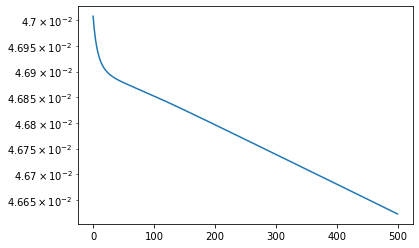

In [ ]:
plt.semilogy(amari_distances)

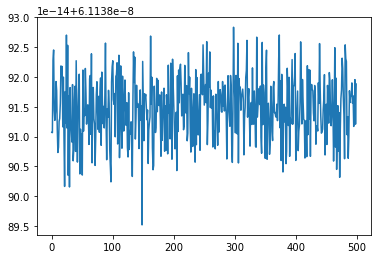

In [ ]:
plt.plot(distances)